## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## Importing Data

In [3]:
# Declare the path to the CSV file that we want to load
path = "D:\My projects\Cookie_Cat_AB_Testing\data\cookie_cats.csv"

# Define a function to load the CSV file and print information about the data
def load(path, info = True):
    """Loads the CSV file specified by the `path` argument and prints information
    about the data if the `info` argument is `True`.

    Args:
        path: The path to the CSV file to load.
        info: A Boolean value specifying whether or not to print information
            about the data.

    Returns:
        A Pandas DataFrame containing the data from the CSV file.
    """
    import pandas as pd
    import io

    # Load the CSV file into a Pandas DataFrame
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)

    # Check if the DataFrame contains any data
    if info:
        if len(read) > 0:
            # Print information about the data if the `info` argument is `True`
            print("# Data imported!")
            print("# ------------------------------------", "\n")

            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("object").columns), "\n",
                      read.select_dtypes("object").columns.tolist(), "\n")

            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("integer").columns), "\n",
                      read.select_dtypes("integer").columns.tolist(), "\n")

            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("float").columns), "\n",
                      read.select_dtypes("float").columns.tolist(), "\n")

            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("bool").columns), "\n",
                      read.select_dtypes("bool").columns.tolist(), "\n")

            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False,
                                                            "No missing value!", "Data includes missing value!"), "\n")

            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)

        else:
            print("# Data did not import!")

    # Return the Pandas DataFrame
    return read

# Load the CSV file and print information about the data
df_cookie = load(path, info = True)

# Print the first five rows of the DataFrame
df_cookie.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 90189 Column: 5 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# Number of Unique User
print(df_cookie.userid.nunique() == df_cookie.shape[0])
# Summary Stats: sum_gamerounds
df_cookie.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [5]:
# Summarize the sum_gamerounds column by version
df_cookie.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


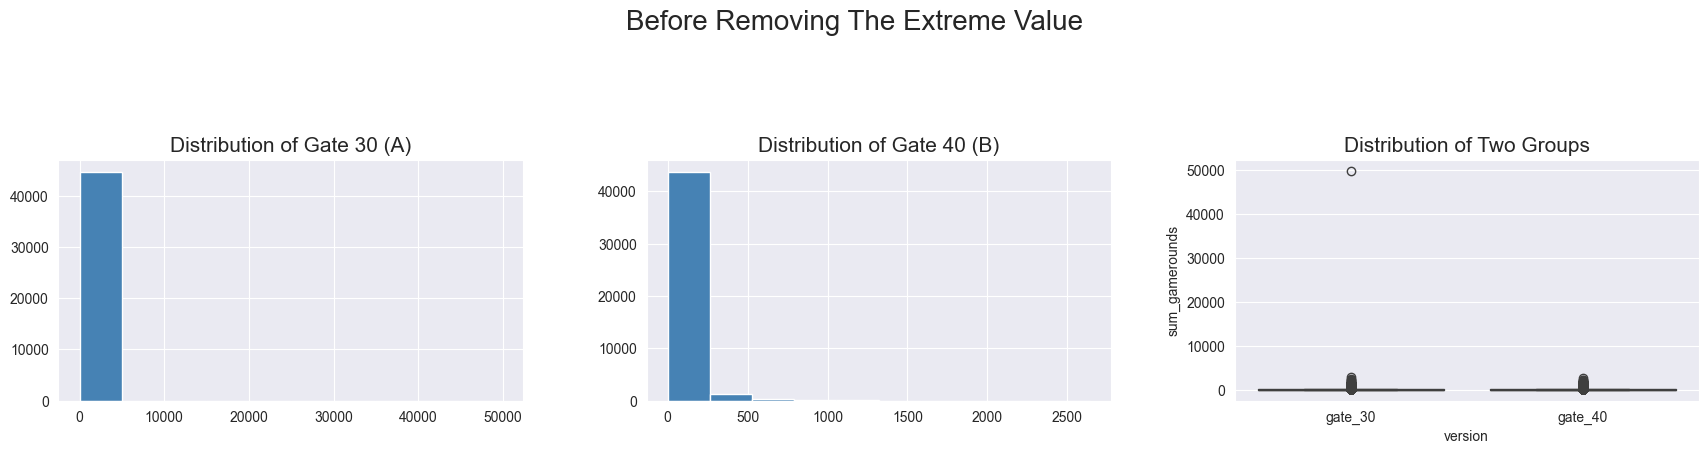

In [6]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the distribution of Gate 30
df_cookie[(df_cookie['version'] == 'gate_30')].hist('sum_gamerounds', ax=axes[0], color='steelblue')

# Plot the distribution of Gate 40
df_cookie[(df_cookie['version'] == 'gate_40')].hist('sum_gamerounds', ax=axes[1], color='steelblue')

# Create a boxplot of the two groups
sns.boxplot(x='version', y='sum_gamerounds', data=df_cookie, ax=axes[2])

# Add titles to the plots
plt.suptitle('Before Removing The Extreme Value', fontsize=20)
axes[0].set_title('Distribution of Gate 30 (A)', fontsize=15)
axes[1].set_title('Distribution of Gate 40 (B)', fontsize=15)
axes[2].set_title('Distribution of Two Groups', fontsize=15)

# Tighten the layout of the figure
plt.tight_layout(pad=4)

# Display the plot
plt.show()

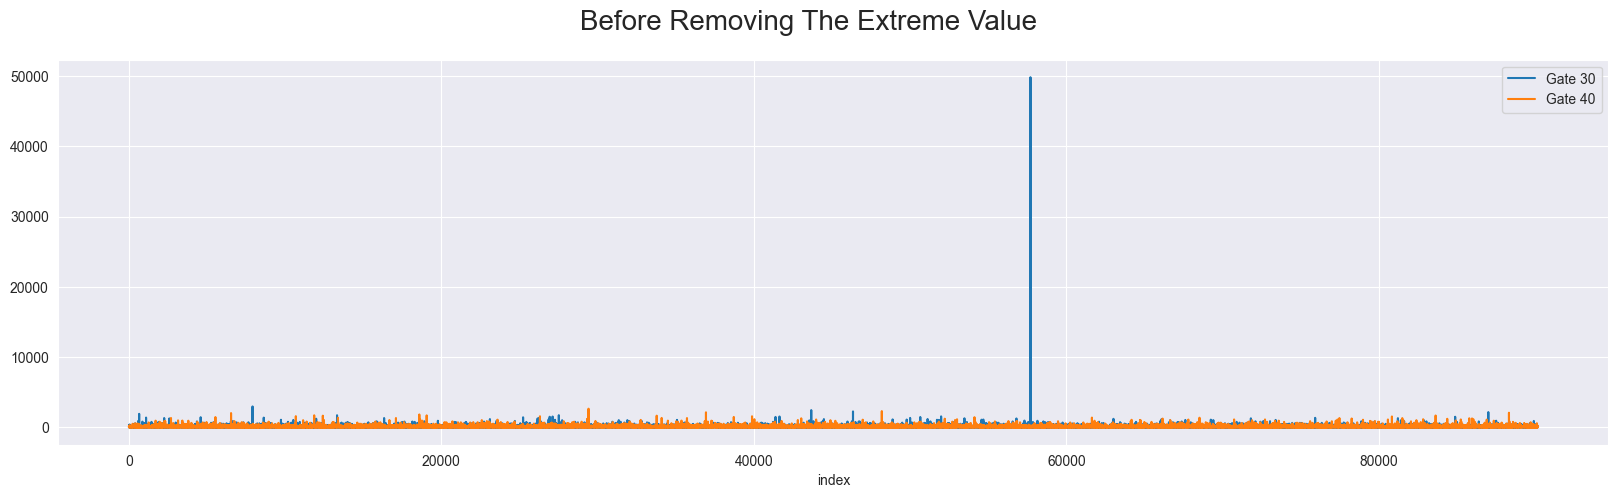

In [7]:
# Plot the sum_gamerounds of each version
df_cookie[df_cookie['version'] == 'gate_30'].reset_index().set_index("index").sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))
df_cookie[df_cookie['version'] == 'gate_40'].reset_index().set_index("index").sum_gamerounds.plot(legend=True, label="Gate 40")

# Add a title to the plot
plt.suptitle('Before Removing The Extreme Value', fontsize=20)

# Display the plot
plt.show()

In [8]:
# Remove the extreme value
df_cookie = df_cookie[df_cookie.sum_gamerounds < df_cookie.sum_gamerounds.max()]

# Calculate summary statistics for sum_gamerounds
df_cookie.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


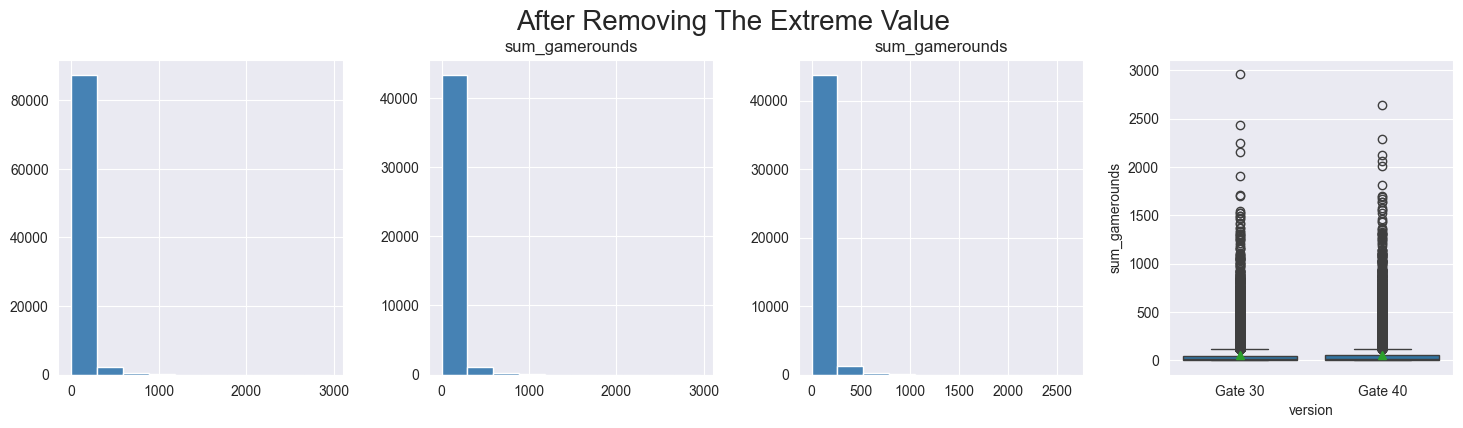

In [9]:
# Create a figure with four subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
# Plot the distribution of total game rounds
df_cookie.sum_gamerounds.hist(ax=axes[0], color="steelblue", label="Total Game Rounds")

# Plot the distribution of Gate 30
df_cookie[(df_cookie['version'] == 'gate_30')].hist('sum_gamerounds', ax=axes[1], color="steelblue", label="Gate 30 (A)")

# Plot the distribution of Gate 40
df_cookie[(df_cookie['version'] == 'gate_40')].hist('sum_gamerounds', ax=axes[2], color="steelblue", label="Gate 40 (B)")

# Create a boxplot of the two groups
sns.boxplot(x='version', y='sum_gamerounds', data=df_cookie, ax=axes[3], showmeans=True)
axes[3].set_xticklabels(['Gate 30', 'Gate 40'])
plt.subplots_adjust(bottom=0.25)
plt.suptitle('After Removing The Extreme Value', fontsize=20)

# Display the plot
plt.show()

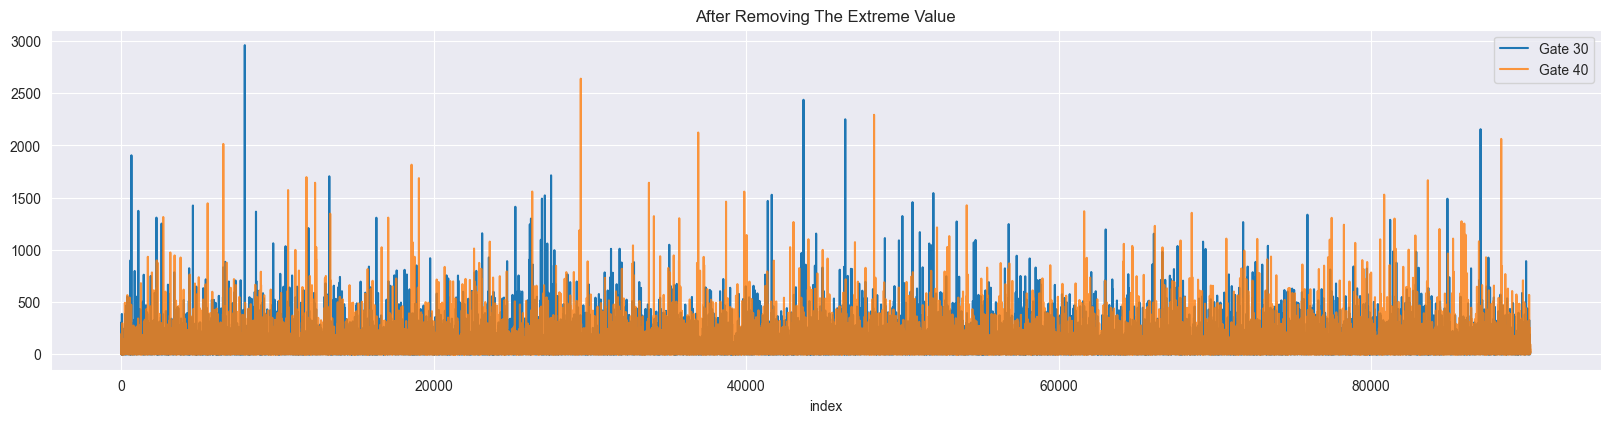

In [10]:
# Plot the sum_gamerounds for each group with different alpha values
df_cookie[(df_cookie['version'] == 'gate_30')].reset_index().set_index("index").sum_gamerounds.plot(
    legend=True, label="Gate 30", figsize=(20, 5), title="After Removing The Extreme Value", alpha=1
)
df_cookie[(df_cookie['version'] == 'gate_40')].reset_index().set_index("index").sum_gamerounds.plot(
    legend=True, label="Gate 40", alpha=0.8
)

plt.subplots_adjust(bottom=0.2)

# Display the plot
plt.show()

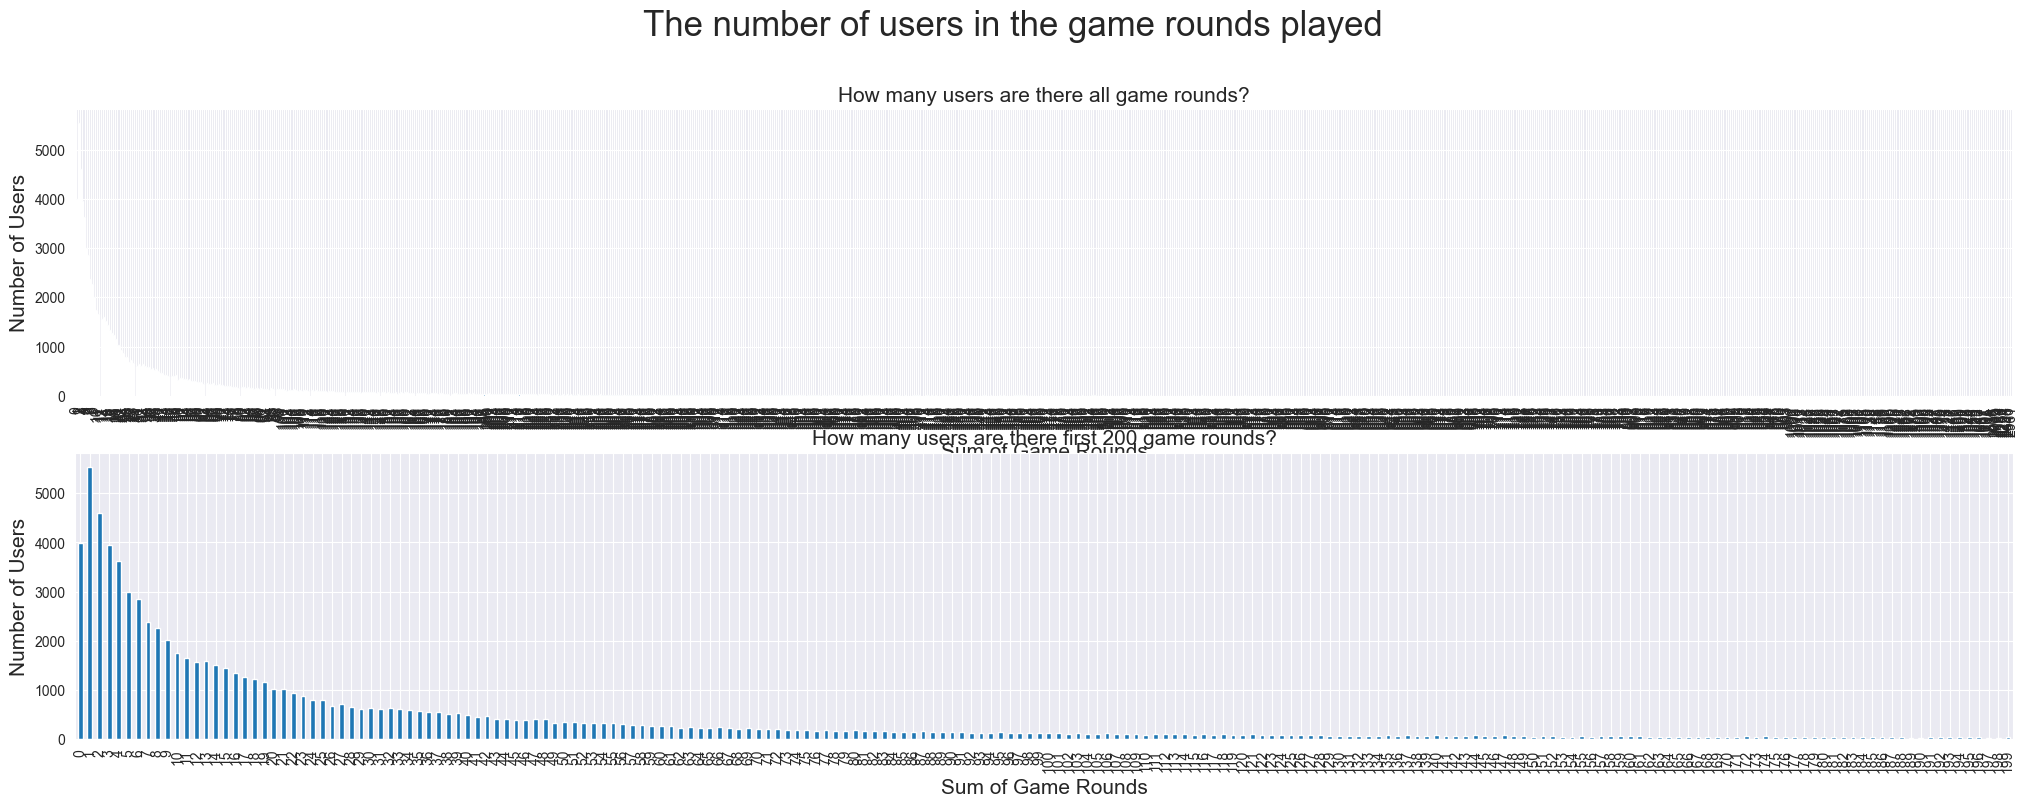

In [11]:
# Plot the number of users in each game round for all game rounds
fig, axes = plt.subplots(2, 1, figsize=(25, 10))
df_cookie.groupby("sum_gamerounds").userid.count().plot(kind="bar", ax=axes[0])
axes[0].set_xlabel("Sum of Game Rounds", fontsize=15)
axes[0].set_ylabel("Number of Users", fontsize=15)
axes[0].set_title("How many users are there all game rounds?", fontsize=15)

# Plot the number of users in each game round for the first 200 game rounds
df_cookie.groupby("sum_gamerounds").userid.count()[:200].plot(kind="bar", ax=axes[1])
axes[1].set_xlabel("Sum of Game Rounds", fontsize=15)
axes[1].set_ylabel("Number of Users", fontsize=15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize=15)

plt.subplots_adjust(bottom=0.25)

plt.suptitle("The number of users in the game rounds played", fontsize=25)

# Display the plot
plt.show()

In [12]:
# Group and count users by sum_gamerounds, top 20
df_cookie.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [13]:
# no. of users reached gate 30 & gate 40 levels
df_cookie.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [14]:
# A/B Groups & Target Summary Stats
df_cookie.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


In [15]:
# Calculate the number of users who retained for 1 day and 7 days
ret1_count = df_cookie["retention_1"].value_counts()
ret7_count = df_cookie["retention_7"].value_counts()

# Calculate the retention rate for each group
ret1_ratio = ret1_count / len(df_cookie)
ret7_ratio = ret7_count / len(df_cookie)

# Create a DataFrame to show the results
df = pd.DataFrame({"RET1_COUNT": ret1_count,
                   "RET7_COUNT": ret7_count,
                   "RET1_RATIO": ret1_ratio,
                   "RET7_RATIO": ret7_ratio})

# Print the DataFrame
print(df)

       RET1_COUNT  RET7_COUNT  RET1_RATIO  RET7_RATIO
False       50035       73408      0.5548      0.8139
True        40153       16780      0.4452      0.1861


In [16]:
# Group the DataFrame by version and retention status for 1 day
grouped_df = df_cookie.groupby(["version", "retention_1"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Print the summary statistics
print(summary_stats)

                     count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640


In [17]:
# Group the DataFrame by version and retention status for 7 days
grouped_df = df_cookie.groupby(["version", "retention_7"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Print the summary statistics
print(summary_stats)

                     count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [19]:
# Add a new column called "Retention"
df_cookie["Retention"] = np.where((df_cookie["retention_1"] == True) & (df_cookie["retention_7"] == True), 1, 0)

# Group the DataFrame by version and retention status
grouped_df = df_cookie.groupby(["version", "Retention"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Print the summary statistics
print(summary_stats)

                   count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294


In [20]:
# Add a new column called "NewRetention"
df_cookie["NewRetention"] = list(map(lambda x, y: str(x) + "-" + str(y), df_cookie["retention_1"], df_cookie["retention_7"]))

In [21]:
# Group the DataFrame by version and NewRetention status
grouped_df = df_cookie.groupby(["version", "NewRetention"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Reset the index of the summary_stats DataFrame
summary_stats = summary_stats.reset_index()

# Print the summary statistics
print(summary_stats)

   version NewRetention  count   median     mean      std   max
0  gate_30  False-False  22840   6.0000  11.8197  21.6426   981
1  gate_30   False-True   1825  43.0000  73.1693  93.2223  1072
2  gate_30   True-False  13358  33.0000  49.6945  58.1254   918
3  gate_30    True-True   6676 127.0000 183.8863 189.6264  2961
4  gate_40  False-False  23597   6.0000  11.9133  20.9010   547
5  gate_40   False-True   1773  47.0000  75.2611  94.4780  1241
6  gate_40   True-False  13613  32.0000  50.0255  60.9246  2640
7  gate_40    True-True   6506 133.0000 190.2824 194.2201  2294


In [22]:
# Define A/B groups
df_cookie["version"] = np.where(df_cookie.version == "gate_30", "A", "B")

# Print the first five rows of the DataFrame
df_cookie.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [24]:
def AB_Test(dataframe, group, target):

    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05

    # Assumption: Homogeneity of variances
    leveneTest = stats.levene(groupA, groupB)[1] < 0.05

    # Select statistical test
    if (ntA == False) & (ntB == False):
        if leveneTest == False:
            # Parametric test
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        else:
            # Non-parametric test
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        # Non-parametric test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]

    # Interpret results
    temp = pd.DataFrame({
        "AB Hypothesis": [ttest < 0.05],
        "p-value": [ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    # Return results
    return temp

# Apply A/B testing
results = AB_Test(dataframe=df_cookie, group="version", target="sum_gamerounds")

# Print results
print(results)

# A/B Testing Hypothesis
H0: A == B
H1: A != B 

        Test Type      AB Hypothesis  p-value                      Comment
0  Non-Parametric  Fail to reject H0   0.0509  A/B groups are not similar!


In [25]:
# Calculate the mean retention rate for 1 day and 7 days for each version
mean_retention_1 = df_cookie.groupby("version").retention_1.mean()
mean_retention_7 = df_cookie.groupby("version").retention_7.mean()

# Print the results
print(mean_retention_1)
print(mean_retention_7)

version
A   0.4482
B   0.4423
Name: retention_1, dtype: float64
version
A   0.1902
B   0.1820
Name: retention_7, dtype: float64
